In [1]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [3]:
from datatools.wfip2 import read_dir, plot_wind

In [4]:
from netCDF4 import Dataset

# Compare WRF model outputs for 2016-11-21
based on `/projects/wfip/MMC/compare_BCs_2016-11-21.ipynb`

In [5]:
tstart = pd.to_datetime('2016-11-21 00:00:00')
tend = pd.to_datetime('2016-11-23 00:00:00')

In [6]:
dpath = {
    'control': '/projects/wfip/WFIP2/control/2016112106',
    'ERA': '/projects/wfip/MMC/20161121_YSU',
    'ERA_CD': '/projects/wfip/MMC/20161121_YSU',
    'ERA_PB': '/scratch/phawbeck/WRF/WFIP2/ERAI/2016112112',
    'improved': '/projects/wfip/WFIP2/improved/extracted',
}
prefix = {
    'control': 'wrfout_d01_2016-11-',
    'ERA': 'wrfout_d01_2016-11-',
    'ERA_CD': 'met_em.d01.2016-11-',
    'ERA_PB': 'met_em.d01.2016-11-',
    'improved': 'wrfout_d01_2016-11-',
}
csvfile = {
    'control': 'wrfout_d01.csv',
    'ERA': 'wrfout_d01_ERA.csv',
    'ERA_CD': 'met_em_d01_ERA_CD.csv',
    'ERA_PB': 'met_em_d01_ERA_PB.csv',
    'improved': 'wrfout_d01_improved.csv',
}
reanalysis = {
    'control': 'GFS',
    'ERA': 'ERA-Interim',
    'ERA_CD': 'ERA-Interim',
    'ERA_PB': 'ERA-Interim',
    'improved': 'unknown',
}
version = {
    'control': 'WRF 3.7+',
    'ERA': 'WRF 3.7.1',
    'ERA_CD': 'METGRID 3.7.1',
    'ERA_PB': 'METGRID 3.7.1',
    'improved': 'WRF 3.9pre#2 (2018-12-07)'
}

## WRF I/O helper functions

In [7]:
def read_wrf_snapshot(fname,
                      probe=(45.638004,-120.642973),
                      heights=np.arange(10,201,10),
                      verbose=True):
    """Read WRF snapshot and vertically interpolate data at the grid point nearest to probe (lat,long)
    
    Default probe location is the WFIP2 PS12 met mast
    """
    if verbose:
        print('Reading WRF snapshot '+fname)
    nc = Dataset(fname)
    Times = nc.variables['Times'][:][0,:]
    tstr = ''.join(Times.astype(str))
    t = pd.to_datetime(tstr,format='%Y-%m-%d_%H:%M:%S')
    xlat = nc.variables['XLAT'][:][0,:,:]
    xlon = nc.variables['XLONG'][:][0,:,:]
    PH = nc.variables['PH'][:][0,:,:]
    PHB = nc.variables['PHB'][:][0,:,:]
    U = nc.variables['U'][:][0,:,:,:]
    V = nc.variables['V'][:][0,:,:,:]
    W = nc.variables['W'][:][0,:,:,:]
    Nlat,Nlon = xlat.shape
    Nlevels = U.shape[0]
    
    # calculate height from pressure levels
    assert(np.all(PH.shape == (Nlevels+1,Nlat,Nlon))) # perturbation geopotential, staggered in Z
    assert(np.all(PHB.shape == (Nlevels+1,Nlat,Nlon))) # base-state geopotential, staggered in Z
    zstag = (PH + PHB) / 9.81
    zstag -= zstag[0] # height above ground level
    z = 0.5*(zstag[1:] + zstag[:-1])
    
    # calculate winds
    assert(np.all(U.shape == (Nlevels,Nlat,Nlon+1))) # staggered in X
    assert(np.all(V.shape == (Nlevels,Nlat+1,Nlon))) # staggered in Y
    assert(np.all(W.shape == (Nlevels+1,Nlat,Nlon))) # staggered in Z
    U = 0.5*(U[:,:,1:] + U[:,:,:-1])
    V = 0.5*(V[:,1:,:] + V[:,:-1,:])
    WS = np.sqrt(U*U + V*V)
    WD = 180./np.pi * np.arctan2(-U,-V)
    WD[WD < 0] += 360.
    
    # interpolate to desired heights
    d2 = (xlat - probe[0])**2 + (xlon - probe[1])**2
    i,j = np.unravel_index(np.argmin(d2), xlat.shape)
    WSprobe = np.interp(heights,z[:,i,j],WS[:,i,j])
    WDprobe = np.interp(heights,z[:,i,j],WD[:,i,j])
    Wprobe = np.interp(heights,zstag[:,i,j],W[:,i,j])
    
    # construct dataframe
    df = pd.DataFrame(data={'height':heights,'speed':WSprobe,'direction':WDprobe,'vert':Wprobe})
    df['datetime'] = t
    
    return df.set_index('datetime')

In [8]:
def read_reanalysis_data(fname,
                         probe=(45.638004,-120.642973),
                         heights=np.arange(10,201,10),
                         verbose=True):
    """Read reanalysis data used for WRF BC/ICs"""
    if verbose:
        print('Reading reanalysis snapshot '+fname)
    nc = Dataset(fname)
    Times = nc.variables['Times'][:][0,:]
    tstr = ''.join(Times.astype(str))
    t = pd.to_datetime(tstr,format='%Y-%m-%d_%H:%M:%S')
    xlat = nc.variables['CLAT'][:][0,:,:] # computational latitude on mass grid [deg], shape==(Time, south_north, west_east)
    xlon = nc.variables['CLONG'][:][0,:,:] # computational longitude on mass grid [deg], shape==(Time, south_north, west_east)
    U = nc.variables['UU'][:][0,:,:,:] # U [m/s], shape==(Time, num_metgrid_levels, south_north, west_east_stag)
    V = nc.variables['VV'][:][0,:,:,:] # V [m/s], shape==(Time, num_metgrid_levels, south_north_stag, west_east)
    z = nc.variables['GHT'][:][0,:,:,:] # Height [m], shape==(Time, num_metgrid_levels, south_north, west_east)
    Nlat,Nlon = xlat.shape
    Nlevels = U.shape[0]
    assert(Nlevels == nc.dimensions['num_metgrid_levels'].size)
    
    # calculate winds
    assert(np.all(U.shape == (Nlevels,Nlat,Nlon+1))) # staggered in X
    assert(np.all(V.shape == (Nlevels,Nlat+1,Nlon))) # staggered in Y
    U = 0.5*(U[:,:,1:] + U[:,:,:-1])
    V = 0.5*(V[:,1:,:] + V[:,:-1,:])
    WS = np.sqrt(U*U + V*V)
    WD = 180./np.pi * np.arctan2(-U,-V)
    WD[WD < 0] += 360.
    
    # extrapolate down to 0-th level
    z[0,:,:] = 0.
    U[0,:,:] = U[1,:,:]
    V[0,:,:] = V[1,:,:]
    
    # interpolate to desired heights
    d2 = (xlat - probe[0])**2 + (xlon - probe[1])**2
    i,j = np.unravel_index(np.argmin(d2), xlat.shape)
    WSprobe = np.interp(heights,z[:,i,j],WS[:,i,j])
    WDprobe = np.interp(heights,z[:,i,j],WD[:,i,j])
#     print(z.shape,(i,j))
#     print(z[:5,i,j])
#     print(WS[:5,i,j])
    
    # construct dataframe
    df = pd.DataFrame(data={'height':heights,'speed':WSprobe,'direction':WDprobe})
    df['datetime'] = t
        
    return df.set_index('datetime')

[751.9288330078125 141.74461364746094 350.9849853515625 564.5615234375
 782.898681640625 1006.7860107421875 1234.776611328125 1467.957275390625
 1706.59912109375 1951.0322265625]


Text(0,0.5,'height [km]')

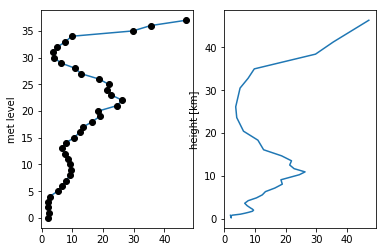

In [9]:
rawdata = np.loadtxt('/projects/wfip/MMC/20161121_YSU/UU_0Z.dump',skiprows=4)
fname = '/projects/wfip/MMC/20161121_YSU/met_em.d01.2016-11-22_00:00:00.nc'
i,j = 174,175
nc = Dataset(fname)
xlat = nc.variables['CLAT'][:][0,i,j]
xlon = nc.variables['CLONG'][:][0,i,j]
U = nc.variables['UU'][:][0,:,i,j]
z = nc.variables['GHT'][:][0,:,i,j]
print(z[:10])
Nz = len(z)
fig,ax = plt.subplots(ncols=2,sharex=True)
ax[0].plot(U,np.arange(Nz))
ax[0].plot(rawdata[:,1],rawdata[:,0],'ko')
ax[1].plot(U,z/1000.)
ax[0].set_ylabel('met level')
ax[1].set_ylabel('height [km]')

## Read WRF output

In [10]:
%%time
# ~30 min for reading control/ERAI
wrf = {}
for case,solndir in dpath.items():
    outfile = os.path.join('data',csvfile[case])
    if os.path.isfile(outfile):
        print('Reading',outfile)
        wrf[case] = pd.read_csv(outfile,parse_dates=['datetime']).set_index('datetime')
    else:
        if prefix[case].startswith('wrfout'):
            wrf[case] = read_dir(solndir,reader=read_wrf_snapshot,
                                 file_filter=prefix[case]+'*',ext='00')
        elif prefix[case].startswith('met_em'):
            wrf[case] = read_dir(solndir,reader=read_reanalysis_data,
                                 file_filter=prefix[case]+'*',ext='.nc')
        print('Writing',outfile)
        wrf[case].to_csv(outfile)

Reading data/wrfout_d01.csv
Reading data/wrfout_d01_ERA.csv
Reading data/met_em_d01_ERA_CD.csv
Reading data/met_em_d01_ERA_PB.csv
Reading data/wrfout_d01_improved.csv
CPU times: user 35.8 ms, sys: 4.14 ms, total: 39.9 ms
Wall time: 74 ms


## Read reference obs

### PS01 sodar

In [11]:
%time sodar = pd.read_csv('/projects/wfip/WFIP2/PS01/sodar.csv',parse_dates=['date_time']).set_index('date_time')

CPU times: user 956 ms, sys: 98.4 ms, total: 1.05 s
Wall time: 807 ms


(0, 200)

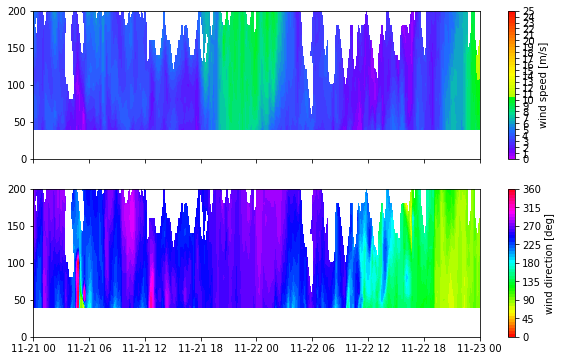

In [12]:
plot_wind(sodar,datetime_range=(tstart,tend))
plt.ylim((0,200))

In [13]:
sodar80 = sodar.loc[(sodar.index >= tstart) & (sodar.index <= tend) & (sodar['height']==80)]

### PS12 lidar

In [14]:
%time lidar = pd.read_csv('/projects/wfip/WFIP2/PS12/Siemens_Nov2016_10min.csv',parse_dates=['datetime'])
lidar = lidar.sort_values(['datetime','height']).set_index('datetime')

CPU times: user 53 ms, sys: 4 ms, total: 57 ms
Wall time: 56.4 ms


(0, 200)

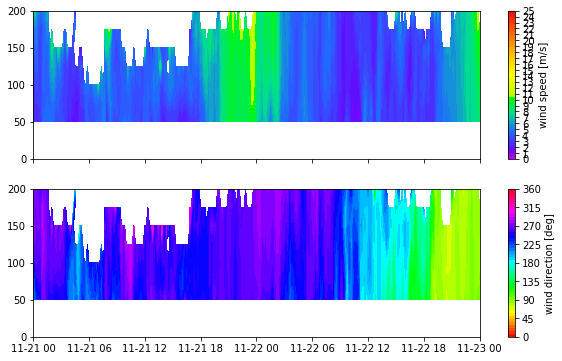

In [15]:
plot_wind(lidar,datetime_range=(tstart,tend))
plt.ylim((0,200))

In [16]:
lidar80 = lidar.loc[(lidar.index >= tstart) & (lidar.index <= tend) & (lidar['height']==80)]

### PS12 met mast

In [17]:
%time met80 = pd.read_csv('/projects/wfip/MMC/PS12met_80m_2016-11-21.csv',parse_dates=['collection_time']).set_index('collection_time')

CPU times: user 3.96 ms, sys: 0 ns, total: 3.96 ms
Wall time: 3.9 ms


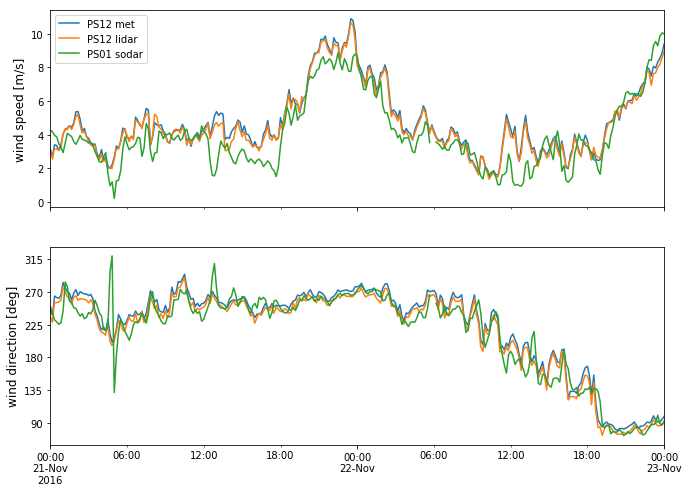

In [18]:
fig,ax = plt.subplots(nrows=2,sharex=True,figsize=(11,8))
met80['wind_speed'].plot(ax=ax[0],label='PS12 met')
lidar80['speed'].plot(ax=ax[0],label='PS12 lidar')
sodar80['speed'].plot(ax=ax[0],label='PS01 sodar')
met80['wind_direction'].plot(ax=ax[1],label='PS12 met')
lidar80['direction'].plot(ax=ax[1],label='PS12 lidar')
sodar80['direction'].plot(ax=ax[1],label='PS01 sodar')
ax[-1].set_xlim((tstart,tend))
ax[-1].set_xlabel('')
ax[0].set_ylabel('wind speed [m/s]',fontsize='large')
ax[1].set_ylabel('wind direction [deg]',fontsize='large')
ax[1].set_yticks(np.arange(90,316,45))
ax[0].legend()
#ttl = fig.suptitle('Physics Site Reference Data')
#fig.savefig('figures/wfip2_refdata_2016-11-21.png',dpi=150,bbox_extra_artists=(ttl,),bbox_inches='tight')
fig.savefig('figures/wfip2_refdata_2016-11-21.png',dpi=150,bbox_inches='tight')

## Comparisons

control
ERA
ERA_CD
ERA_PB
improved


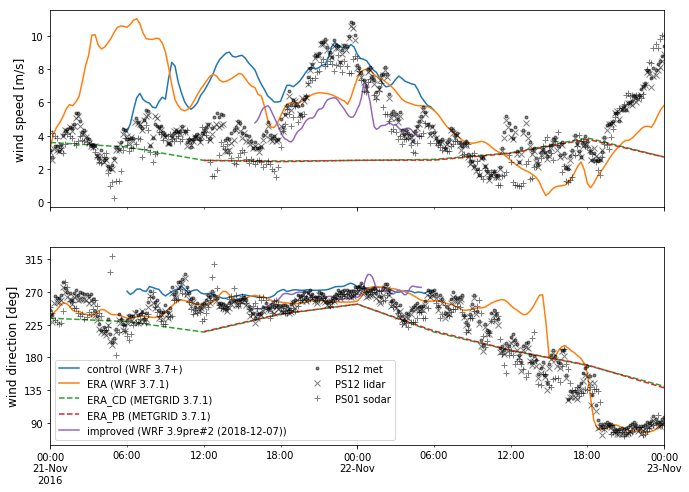

In [19]:
fig,ax = plt.subplots(nrows=2,sharex=True,figsize=(11,8))

for case,data in wrf.items():
    print(case)
    if prefix[case].startswith('wrfout'):
        ls = '-'
        #label = case
    elif prefix[case].startswith('met_em'):
        ls = '--'
        #label = case + ' (BC)'
    label = '{:s} ({:s})'.format(case,version[case])
    wspd = data.loc[data['height']==80,'speed']
    wdir = data.loc[data['height']==80,'direction']
    wspd.plot(ax=ax[0],ls=ls,label=label)
    wdir.plot(ax=ax[1],ls=ls,label=label)

met80['wind_speed'].plot(ax=ax[0],color='k',ls='none',marker='.',alpha=0.5,label='PS12 met')
lidar80['speed'].plot(ax=ax[0],color='k',ls='none',marker='x',alpha=0.5,label='PS12 lidar')
sodar80['speed'].plot(ax=ax[0],color='k',ls='none',marker='+',alpha=0.5,label='PS01 sodar')
met80['wind_direction'].plot(ax=ax[1],color='k',ls='none',marker='.',alpha=0.5,label='PS12 met')
lidar80['direction'].plot(ax=ax[1],color='k',ls='none',marker='x',alpha=0.5,label='PS12 lidar')
sodar80['direction'].plot(ax=ax[1],color='k',ls='none',marker='+',alpha=0.5,label='PS01 sodar')

ax[-1].set_xlim((tstart,tend))
ax[-1].set_xlabel('')
ax[0].set_ylabel('wind speed [m/s]',fontsize='large')
ax[1].set_ylabel('wind direction [deg]',fontsize='large')
ax[1].set_yticks(np.arange(90,316,45))
ax[1].plot(tstart,270,ls='none',label=' ') # silly workaround to shift legend item
ax[1].legend(ncol=2)
fig.savefig('figures/wfip2_models_2016-11-21.png',dpi=150,bbox_inches='tight')